In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [2]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        self.m = m
        self.w = np.pi
        self.k = self.m*np.square(self.w)
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        self.l = np.cross(self.r,self.p)
        self.f = np.array([-1*self.r[0]*self.k,0.])
        self.ek = 0.5*self.m*np.dot(self.v,self.v)
        self.eu = 0.5*self.k*np.square(self.r[0])
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
    
        # Fisica
        
        self.Ek = np.zeros(len(t))
        self.Eu = np.zeros_like(self.Ek)
        self.L = np.zeros_like(self.Ek)
        
    def Evolution(self,i):
        
        self.SetPosition(i)
        self.SetVelocity(i)
        self.SetMomentum(i)
        self.SetAngularMomentum(i)
        self.SetKineticEnergy(i)
        self.SetPotentialEnergy(i)
        
        self.ek = 0.5*self.m*np.dot(self.v,self.v)
        self.eu = 0.5*self.k*np.square(self.r[0])
        
        self.f = np.array([-1*self.r[0]*self.k,0.])
        self.a = self.f/self.m

        if i == 0:
            # Euler-Cromer
            self.v += self.dt*self.a
            self.r += self.dt*self.v
            
        
        # Euler
        #self.r += self.dt*self.v
        #self.v += self.dt*self.a
        
        else:
            # Verlet
            self.r = 2*self.R[i] - self.R[i-1] + self.a*np.square(self.dt)
            self.v = (self.r - self.R[i-1])/(2*self.dt)
        
        
        self.p = self.m*self.v
        self.l = np.cross(self.r,self.p)
        
            
     
    # Aca debes agregar la energía potencial
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
        self.eu = 0.
    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        
    def SetMomentum(self,i):
        self.P[i] = self.p
        
    def SetAngularMomentum(self,i):
        self.L[i] = self.l
        
    def SetKineticEnergy(self,i):
        self.Ek[i] = self.ek
        
    def SetPotentialEnergy(self,i):
        self.Eu[i] = self.eu
    
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetAngularMomentum(self,scale=1):
        return self.L[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.Ek[::scale]
    
    def GetPotentialEnergy(self,scale=1):
        return self.Eu[::scale]
    
    # Debes agregar las paredes en este punto
    
    def CheckLimits(self):
        
        Limits = np.array([[-20.,20.],[-2.,20.]])
        
        for i in range(2):
        
            if self.r[i] + self.radius > Limits[i][1] and self.v[i] > 0.:
                self.v[i] = -1.0*self.v[i]
            if self.r[i] - self.radius < Limits[i][0] and self.v[i] < 0.:
                self.v[i] = -1.0*self.v[i]

In [3]:
def GetParticles(N,t):

    Particles = [0]

    
    r0 = np.array([1., 0.])
    v0 = np.array([1., 0.])
    a0 = np.array([-1.*1.*np.square(np.pi),0.])
    p = Particle(r0,v0,a0,t,m=1,radius=2,Id=0)
    Particles[0] = p
    
    # Aca deber agregar una rutina montecarlo para crear particulas
    # sobre el plano con velocidades aleatorias.
    
    return Particles

In [4]:
dt = 0.001
tmax = 10
t = np.arange(0,tmax,dt)
Particles = GetParticles(10,t)

In [5]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            #Particles[i].ResetForce()
            
            # Aca debes agregar la interaccion con la pared
            
            #Particles[i].CheckLimits()
            
            
    return Particles

In [6]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|██████████| 10000/10000 [00:00<00:00, 21110.09 Steps/s]


In [7]:
# Bajamos dimensión de la simulacion
scale = 200
t1 = t[::scale]

<IPython.core.display.Javascript object>


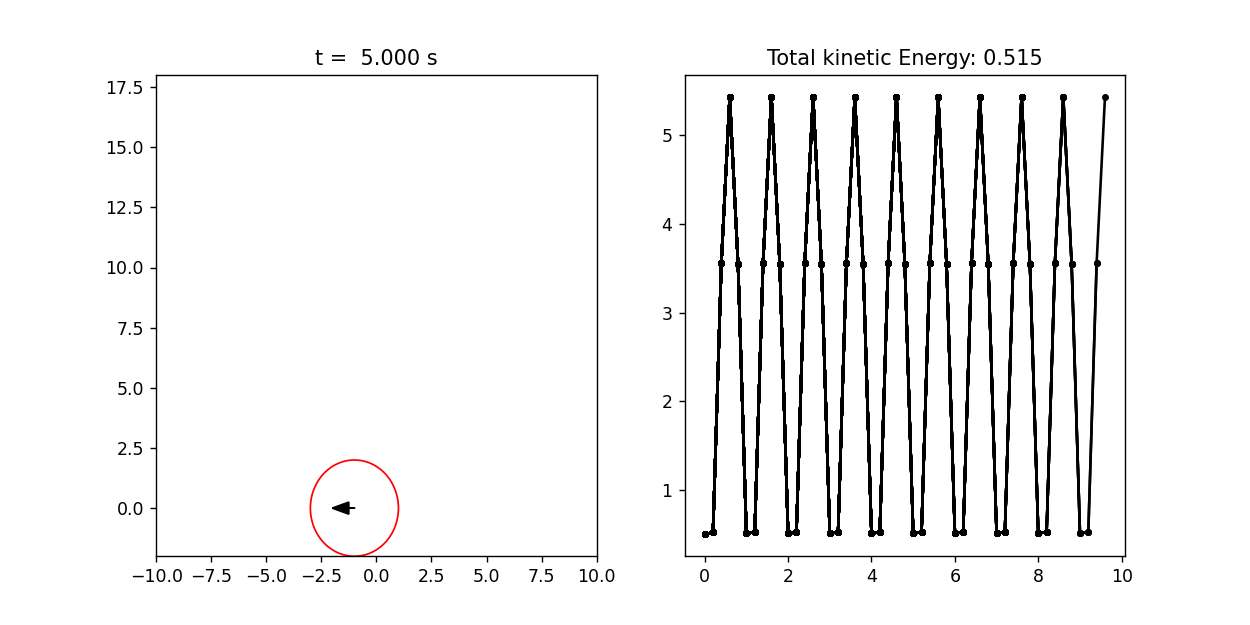

In [8]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
KEtotal = np.zeros(len(t1))

def init():
    
    ax.clear()
    ax.set_xlim(-10,10)
    ax.set_ylim(-2,18)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KEcurrent = 0. # Kinetic energy
    KUcurrent = 0. # Potential energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KEcurrent += p.GetKineticEnergy(scale)[i]
        
    KEtotal[i] = KEcurrent
        
    ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KEcurrent))
    ax1.plot(t1[:i], KEtotal[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

<IPython.core.display.Javascript object>


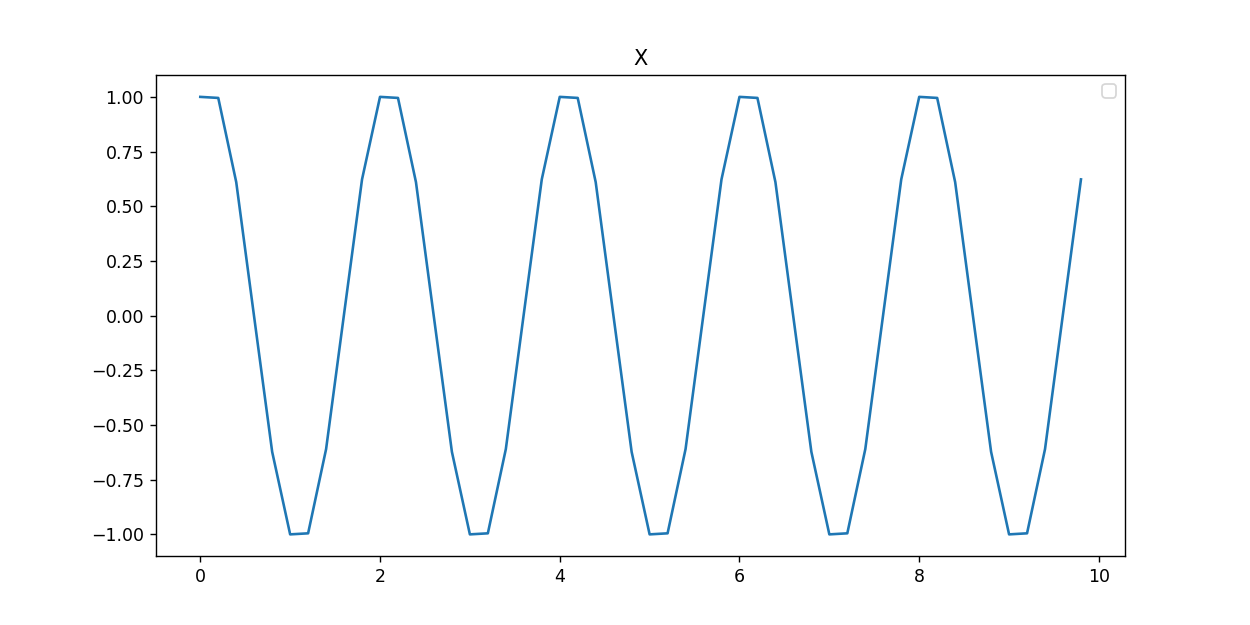

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [9]:
fig5 = plt.figure(figsize=(10,5))
ax5 = fig5.add_subplot(111)
ax5.plot(t1,Particles[0].GetPosition(scale)[:, 0])
ax5.set_title("X")
ax5.legend()

In [10]:
dt2 = 0.7
tmax = 10
t2 = np.arange(0,tmax,dt2)
Particles2 = GetParticles(10,t2)

In [11]:
scale2 = 1

In [12]:
def RunSimulation2(t,Particles):
    
    for it2 in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it2)
            #Particles[i].ResetForce()
            
            # Aca debes agregar la interaccion con la pared
            
            #Particles[i].CheckLimits()
            
            
    return Particles

In [13]:
Particles2 = RunSimulation2(t2,Particles2)

Running simulation: 100%|██████████| 15/15 [00:00<00:00, 3435.33 Steps/s]


<IPython.core.display.Javascript object>


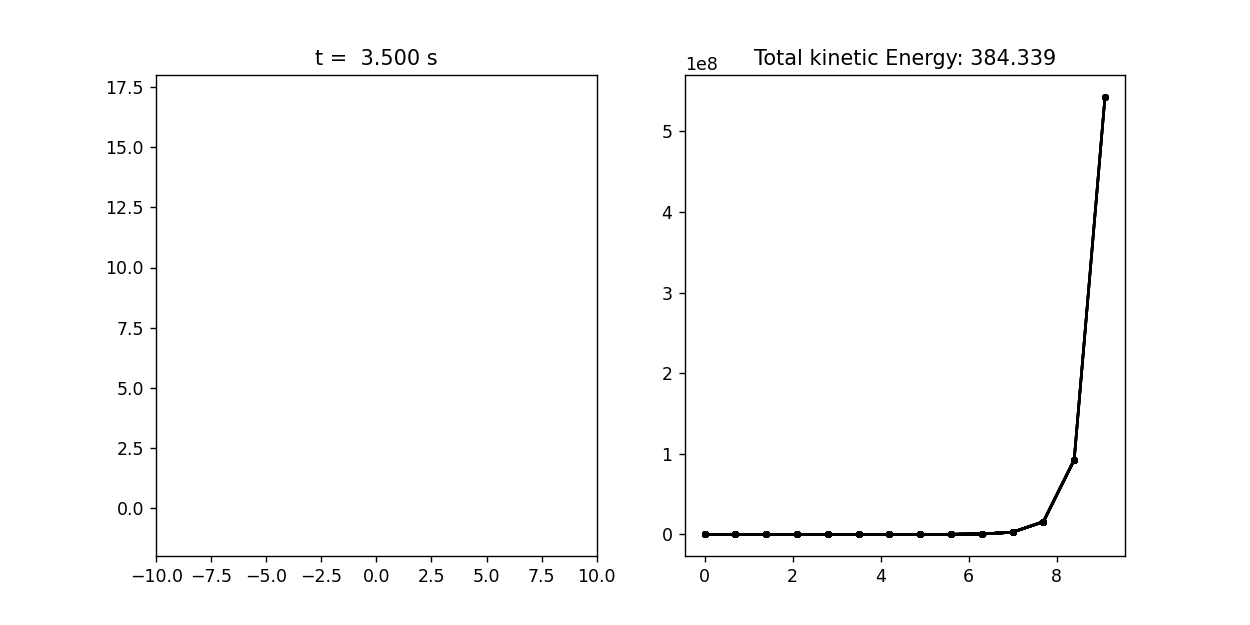

In [14]:
fig2 = plt.figure(figsize=(10,5))
ax2 = fig2.add_subplot(121)
ax3 = fig2.add_subplot(122)
KEtotal2 = np.zeros(len(t2))

def init2():
    
    ax2.clear()
    ax2.set_xlim(-10,10)
    ax2.set_ylim(-2,18)
    
def Update2(i):
    
    init2()
    ax2.set_title(r't =  %.3f s' %(t2[i]))
    
    
    # Queremos calcular la energía total de cinética
    KEcurrent2 = 0. # Kinetic energy
    KUcurrent2 = 0. # Potential energy
    
    for p2 in Particles2:
        
        x2 = p2.GetPosition(scale2)[i,0]
        y2 = p2.GetPosition(scale2)[i,1]
        
        vx2 = p2.GetVelocity(scale2)[i,0]
        vy2 = p2.GetVelocity(scale2)[i,1]
        
        circle = plt.Circle( (x2,y2), p2.radius, color='r', fill=False )
        ax2.add_patch(circle)
        
        ax2.arrow(x2,y2,vx2,vy2,color='k',head_width=0.5,length_includes_head=True)
        
        KEcurrent2 += p2.GetKineticEnergy(scale2)[i]
        
    KEtotal2[i] = KEcurrent2
        
    ax3.set_title(r'Total kinetic Energy: {:.3f}'.format(KEcurrent2))
    ax3.plot(t2[:i], KEtotal2[:i],color='k',marker='.')
        
Animation2 = anim.FuncAnimation(fig2,Update2,frames=len(t2),init_func=init2)

<IPython.core.display.Javascript object>


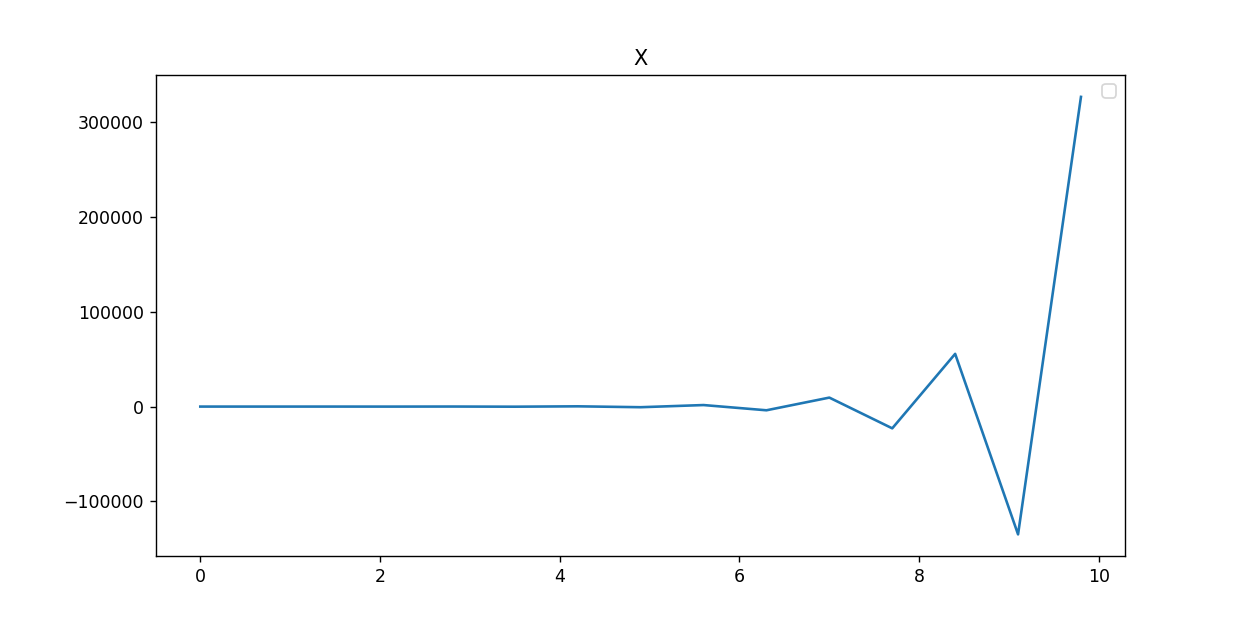

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [15]:
fig6 = plt.figure(figsize=(10,5))
ax6 = fig6.add_subplot(111)
ax6.plot(t2,Particles2[0].GetPosition(scale2)[:, 0])
ax6.set_title("X")
ax6.legend()